## Import

In [19]:
import random
import pandas as pd
import numpy as np
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

import torch

## Hyperparameter Setting

In [4]:
CFG = {
    'SR':16000,
    'N_MELS':128, # MFCC 벡터를 추출할 개수 (<=128)
    'SEED':41
}

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [6]:
train_df = pd.read_csv('./data/open/train.csv') # 모두 정상 Sample
test_df = pd.read_csv('./data/open/test.csv')

In [7]:
train_df['SAMPLE_PATH']=train_df['SAMPLE_PATH'].str.replace('./train','./data/open/train')

In [8]:
test_df['SAMPLE_PATH']=test_df['SAMPLE_PATH'].str.replace('./test','./data/open/test')

In [9]:
test_df

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE
0,TEST_0000,./data/open/test/TEST_0000.wav,2
1,TEST_0001,./data/open/test/TEST_0001.wav,2
2,TEST_0002,./data/open/test/TEST_0002.wav,0
3,TEST_0003,./data/open/test/TEST_0003.wav,0
4,TEST_0004,./data/open/test/TEST_0004.wav,0
...,...,...,...
1509,TEST_1509,./data/open/test/TEST_1509.wav,0
1510,TEST_1510,./data/open/test/TEST_1510.wav,2
1511,TEST_1511,./data/open/test/TEST_1511.wav,0
1512,TEST_1512,./data/open/test/TEST_1512.wav,0


In [14]:
def get_mel_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=CFG['N_MELS'])

        # 추출된 MFCC들의 평균을 Feature로 사용
        y_feature=np.mean(mfcc,axis=1)
        features.append(y_feature)
    return features

In [15]:
train_0_features = get_mel_feature(train_df[train_df['FAN_TYPE']==0])
test_0_features = get_mel_feature(test_df[test_df['FAN_TYPE']==0])

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

In [16]:
train_2_features = get_mel_feature(train_df[train_df['FAN_TYPE']==2])
test_2_features = get_mel_feature(test_df[test_df['FAN_TYPE']==2])

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

In [25]:
train_0_loader = torch.utils.data.DataLoader(
    dataset     = train_0_features,
    batch_size  = 32,
    shuffle     = True,
    num_workers = 0
)
test_0_loader = torch.utils.data.DataLoader(
    dataset     = test_0_features,
    batch_size  = 32,
    shuffle     = True,
    num_workers = 0
)

In [27]:
train_2_loader = torch.utils.data.DataLoader(
    dataset     = train_2_features,
    batch_size  = 32,
    shuffle     = True,
    num_workers = 0
)
test_2_loader = torch.utils.data.DataLoader(
    dataset     = test_2_features,
    batch_size  = 32,
    shuffle     = True,
    num_workers = 0
)

## Model Fit

In [29]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [30]:
# 하이퍼파라미터 준비
EPOCH = 10
BATCH_SIZE = 32
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [32]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #인코더는 간단한 신경망으로 분류모델처럼 생겼습니다.
        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다 (출력값이 바로 잠재변수가 됩니다.)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), #디코더는 차원을 점차 28*28로 복원합니다.
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 잠재변수를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [33]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) 
# Adam()을 최적화함수로 사용합니다. Adam은 SGD의 변형함수이며 학습중인 기울기를 참고하여 학습 속도를 자동으로 변화시킵니다.
criterion = nn.MSELoss() #원본값과 디코더에서 나온 값의 차이를 계산하기 위해 평균제곱오차(Mean Squared Loss) 오차함수를 사용합니다.

In [42]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step,x in enumerate(train_loader):
        x = x.view(-1, 128).to(DEVICE) #x(입력)와 y(대상 레이블)모두 원본이미지(x)인 것을 주의해야 합니다.
        y = x.view(-1, 128).to(DEVICE) #x(입력)와 y(대상 레이블)모두 원본이미지(x)인 것을 주의해야 합니다.
        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) # decoded와 원본이미지(y) 사이의 평균제곱오차를 구합니다
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.    


In [44]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28) #원본이미지 200개를 준비합니다
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

NameError: name 'trainset' is not defined

In [43]:
#학습하기
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기
    # 앞서 시각화를 위해 남겨둔 5개의 이미지를 한 이폭만큼 학습을 마친 모델에 넣어 복원이미지를 만듭니다.
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

NameError: name 'view_data' is not defined

In [12]:
model0 = IsolationForest(n_estimators=200, max_samples=256, contamination='auto', random_state=CFG['SEED'], verbose=0)
model0.fit(train_0_features)

IsolationForest(max_samples=256, n_estimators=200, random_state=41)

In [13]:
model2 = IsolationForest(n_estimators=200, max_samples=256, contamination='auto', random_state=CFG['SEED'], verbose=0)
model2.fit(train_2_features)

IsolationForest(max_samples=256, n_estimators=200, random_state=41)

In [17]:
test_pred_proba0 = model0.decision_function(test_0_features)

threshold = 0.05
pred0 = (test_pred_proba0<threshold)*1

(array([  3.,  13.,  19.,  14.,  21.,  30., 111., 181., 169., 218.]),
 array([-0.1593045 , -0.12608321, -0.09286191, -0.05964061, -0.02641932,
         0.00680198,  0.04002328,  0.07324458,  0.10646587,  0.13968717,
         0.17290847]),
 <BarContainer object of 10 artists>)

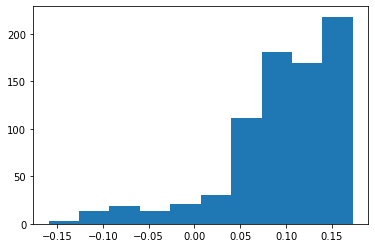

In [18]:
import matplotlib.pyplot as plt

plt.hist(test_pred_proba0)

In [19]:
pred0.mean()

0.1540436456996149

In [23]:
test_pred_proba2 = model2.decision_function(test_2_features)

threshold = -0.07
pred2 = (test_pred_proba2<threshold)*1

(array([ 10.,  27.,  73.,  85., 172.,  14.,   6.,  19., 144., 185.]),
 array([-0.21561779, -0.17856105, -0.14150432, -0.10444758, -0.06739084,
        -0.03033411,  0.00672263,  0.04377937,  0.0808361 ,  0.11789284,
         0.15494958]),
 <BarContainer object of 10 artists>)

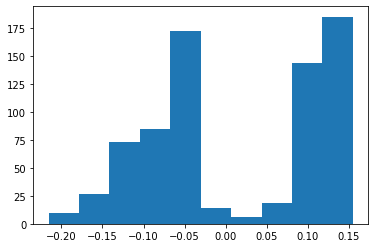

In [24]:
import matplotlib.pyplot as plt

plt.hist(test_pred_proba2)

In [25]:
pred2.mean()

0.25578231292517006

## Prediction

In [85]:
# def get_pred_label(model_pred):
#     # IsolationForest 모델 출력 (1:정상, -1:불량) 이므로 (0:정상, 1:불량)로 Label 변환
#     model_pred = np.where(model_pred == 1, 0, model_pred)
#     model_pred = np.where(model_pred == -1, 1, model_pred)
#     return model_pred

In [86]:
# test_pred = model.predict(test_features) # model prediction
# test_pred = get_pred_label(test_pred)

## Submission

In [26]:
submit = pd.read_csv('./data/open/sample_submission.csv')

In [27]:
test_df2=test_df[test_df['FAN_TYPE']==2]
test_df2['LABEL']=pred2

In [28]:
test_df0=test_df[test_df['FAN_TYPE']==0]
test_df0['LABEL']=pred0

In [29]:
submit=pd.concat( [ test_df0[['SAMPLE_ID','LABEL']], test_df2[['SAMPLE_ID','LABEL']]], axis=0)
submit=submit.sort_values(by='SAMPLE_ID')

In [30]:

submit.head()

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,0
4,TEST_0004,0


In [31]:
submit.to_csv('./submit.csv', index=False)